AI Genomics 


In [1]:
from os.path import join
from google.colab import drive
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
ROOT = "/content/drive"
drive.mount(ROOT,force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# git clone https://github.com/mandanasmi/TCGA_Benchmark
# to get TCGA dataset
PROJ = "My Drive/AI4genomics/TCGA_Benchmark-master"
PROJECT_PATH = join(ROOT, PROJ)

In [0]:
from importlib.machinery import SourceFileLoader
TCGA = SourceFileLoader('tcga', join(PROJECT_PATH, 'meta_dataloader/TCGA.py')).load_module()

In [0]:
import sys
import numpy as np
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2

In [4]:
tasks = TCGA.TCGAMeta(min_samples_per_class=10)  

/content/drive/My Drive/AI4genomics/TCGA_Benchmark-master/meta_dataloader/TCGA.py:39: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(hdf_file)


In [5]:
print(len(tasks.task_ids))
for i, taskid in enumerate(sorted(tasks.task_ids)):
    print(i, taskid)

174
0 ('Expression_Subtype', 'LUAD')
1 ('Expression_Subtype', 'LUNG')
2 ('GeneExp_Subtype', 'GBM')
3 ('Metastasis_nature2012', 'BRCA')
4 ('Node_nature2012', 'BRCA')
5 ('PAM50Call_RNAseq', 'BRCA')
6 ('_EVENT', 'ACC')
7 ('_EVENT', 'BLCA')
8 ('_EVENT', 'BRCA')
9 ('_EVENT', 'CESC')
10 ('_EVENT', 'CHOL')
11 ('_EVENT', 'COAD')
12 ('_EVENT', 'COADREAD')
13 ('_EVENT', 'ESCA')
14 ('_EVENT', 'GBM')
15 ('_EVENT', 'GBMLGG')
16 ('_EVENT', 'HNSC')
17 ('_EVENT', 'KICH')
18 ('_EVENT', 'KIRP')
19 ('_EVENT', 'LAML')
20 ('_EVENT', 'LGG')
21 ('_EVENT', 'LIHC')
22 ('_EVENT', 'LUAD')
23 ('_EVENT', 'LUNG')
24 ('_EVENT', 'LUSC')
25 ('_EVENT', 'MESO')
26 ('_EVENT', 'OV')
27 ('_EVENT', 'PAAD')
28 ('_EVENT', 'READ')
29 ('_EVENT', 'SARC')
30 ('_EVENT', 'SKCM')
31 ('_EVENT', 'STAD')
32 ('_EVENT', 'THCA')
33 ('_EVENT', 'UCEC')
34 ('_EVENT', 'UCS')
35 ('_EVENT', 'UVM')
36 ('_PANCAN_DNAMethyl_BLCA', 'BLCA')
37 ('_PANCAN_DNAMethyl_BRCA', 'BRCA')
38 ('_PANCAN_DNAMethyl_HNSC', 'HNSC')
39 ('_PANCAN_DNAMethyl_LUAD', 'LUAD

## Pytorch Dataset & Dataloader


In [0]:
def createFeatureMatrix(nb_tasks=173):
  
    # Compute gene features (genewise mean across tasks) (matrice Embed(X^T)) 
    all_features = []
    for i, taskid in enumerate(sorted(tasks.task_ids)):
        print(i, taskid)
        task = TCGA.TCGATask(taskid)
        task_mean = np.mean(task._samples, axis=0)
        task_min = np.min(task._samples, axis=0)
        task_max = np.max(task._samples, axis=0)
        task_var = np.var(task._samples, axis=0)
        task_med = np.median(task._samples, axis=0)
        task_features = np.stack((task_mean, task_min, task_max, task_var, task_med), axis=1)
        # print(task_features.shape)
        all_features.append(task_features)
        if i == nb_tasks:
          break

    features = np.concatenate(all_features, axis=1)
    print(features.shape)

    np.save(PROJECT_PATH+'/fullmatrix'+ str(nb_tasks), features)
    return features

In [0]:
# creating the FeatureMatrix.
fullmatrix_5feat = createFeatureMatrix()

In [0]:
# np.save(PROJECT_PATH+'/fullmatrix_5feat.npy', fullmatrix_5feat)

In [8]:
### loading previously computed feature matrix
fullmatrix = np.load(PROJECT_PATH+'/fullmatrix174.npy')
fullmatrix_5feat = np.load(PROJECT_PATH+'/fullmatrix_5feat.npy')
print(fullmatrix.shape)
print(fullmatrix_5feat.shape)

(174, 20530)
(20530, 870)


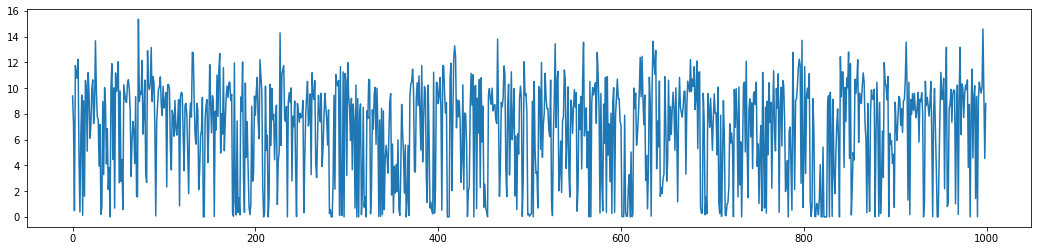

In [0]:
plt.figure(figsize=(18,4))
plt.plot(fullmatrix[0,:1000])
plt.show()

In [0]:
# class TCGADataset(Dataset):
#     def __init__(self, tasks, task_nb, matrix):
#       """
#       task_nb: numero de la tache qui nous interesse
#       """
#       self.task_nb = task_nb
#       self.matrix = matrix

#       for i, taskid in enumerate(sorted(tasks.task_ids)):
#         if i == task_nb:
#           print(taskid)
#           main_task = TCGA.TCGATask(taskid)
#           break

#       self.data = main_task._samples
#       self.labels = main_task._labels

#     def getFeatureMatrix(self):
        
#         feature_matrix = np.delete(self.matrix, self.task_nb, 0)
#         return feature_matrix

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # TODO
#         return self.data[idx], self.labels[idx]

In [0]:
def load_sets(task, train, test, valid=False):
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                task._labels, 
                                                                                stratify=task._labels,
                                                                                train_size=train,
                                                                                test_size=test,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                                 )
    
    train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

    # if valid:
    #     X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_test, 
    #                                                                             y_test, 
    #                                                                             stratify=y_test,
    #                                                                             train_size=50,
    #                                                                             test_size=50,
    #                                                                             shuffle=True,
    #                                                                             random_state=0
    #                                                                            )
    #     valid_set = TensorDataset( Tensor(X_valid), Tensor(y_valid))
    #     return train_set, valid_set, test_set
    
    return train_set, test_set 

In [10]:
# taskid=('Expression_Subtype', 'LUAD')   # 0
# taskid=('_EVENT', 'BLCA')               # 7
taskid = ('_EVENT', 'OV')              # 26
task = TCGA.TCGATask(taskid)

nb_samples = task._samples.shape[0]
input_size = task._samples.shape[1]
num_classes = len(collections.Counter(task._labels))
print('samples: ', nb_samples)
print('input size: ', input_size)
print('number of classes: ', num_classes)

# train_set, test_set = load_sets(task, train=190, test=85, valid = False) # TASK 0 
# train_set, test_set = load_sets(task, train=295, test=127, valid = False)  # TASK 7
train_set, test_set = load_sets(task, train=215, test=92, valid = False)  # TASK 26

samples:  307
input size:  20530
number of classes:  2


In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [11]:
# Removing first line from fullmatrix to get feature_matrix for task number x.
task_nb = 26
feature_matrix = np.delete((fullmatrix), task_nb, 0)
print(feature_matrix.shape)

(173, 20530)


In [12]:
# Removing first line from fullmatrix to get feature_matrix for task number x.
# task_nb = [0,1,2,3,4]
# task_nb = [35,36,37,38,39]
task_nb = [130,131,132,133,134]
feature_matrix5 = np.delete(np.transpose(fullmatrix_5feat), task_nb, 0)
print(feature_matrix5.shape)

(865, 20530)


## Diet Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class MLP(nn.Module):
    def __init__(self, num_classes, device, embedding_size=128, hidden=64):   #, feature_matrix):
        super(MLP, self).__init__()
        self.embedding_size = embedding_size
        self.number_of_genes = 20530
        self.hidden = hidden

        # Definir les parametres du reseau principal
        self.encoder = nn.Linear(self.number_of_genes, self.embedding_size) 
        self.layer2  = nn.Linear(self.embedding_size, self.hidden)
        self.layer3  = nn.Linear(self.hidden, num_classes) 

    def forward(self, x):
        x = F.relu(self.encoder(x.float()))
        x = F.relu(self.layer2(x))
        y_hat = self.layer3(x)
        return y_hat

In [0]:
### FOR MLP ###
criterion = nn.CrossEntropyLoss()   # pour MLP

def train_pass(model, data_loader, optimizer, device):
    model.train()

    pass_loss = 0.0
    total = 0.0
    correct = 0.0

    for batch, labels in data_loader:
        labels = torch.autograd.Variable(labels.long())
        
        batch = batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)        
        pass_loss += loss.item()

        predicted = predicted.cpu().numpy()
        labels = labels.cpu().numpy()
        total += len(labels)
        correct += (predicted == labels).sum()
    accuracy = (100 * correct / total)

    return pass_loss/len(data_loader), accuracy

def test_pass(model, data_loader, device):
  pass_loss = 0.0

  for inputs, labels in data_loader:
        
      inputs = inputs.to(device)
      labels = labels.to(device).long()
      
      model.eval()
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)
      pass_loss += loss.item()

      predicted = predicted.cpu().numpy()
      labels = labels.cpu().numpy()

      total = len(labels)
      correct = (predicted == labels).sum()
      accuracy = (100 * correct / total)

      return pass_loss/len(data_loader), accuracy

def run_training(model, nb_epochs, train_loader, test_loader, device):

  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  progress_bar = tqdm(range(nb_epochs))
  loss_history = []
  best_acc = 0
  for epoch in (progress_bar):
      train_loss, train_acc = train_pass(model, train_loader, optimizer, device)
      test_loss, test_acc = test_pass(model, test_loader, device)
      loss_history.append(
          {"loss": train_loss, "accuracy": train_acc, "set": "train", "epochs": epoch}
      )
      loss_history.append(
          {"loss": test_loss, "accuracy": test_acc,"set": "test", "epochs": epoch}
      )
      if test_acc>best_acc:
        best_acc = test_acc
  print("best test accuracy: ", best_acc)      
  return pd.DataFrame(loss_history)

In [0]:
### MLP TRAIN ###
seed=0
device="cuda"
random.seed(seed)
torch.manual_seed(seed)
MLP_model = MLP(num_classes, device, embedding_size=128, hidden=64)
training_history = run_training(MLP_model, 250, train_loader, test_loader, device)

In [0]:
test = training_history[training_history.set == 'test']
print(test.accuracy.max())
last100 = test[-100:]
print(last100.accuracy.mean())

65.21739130434783
62.36956521739129


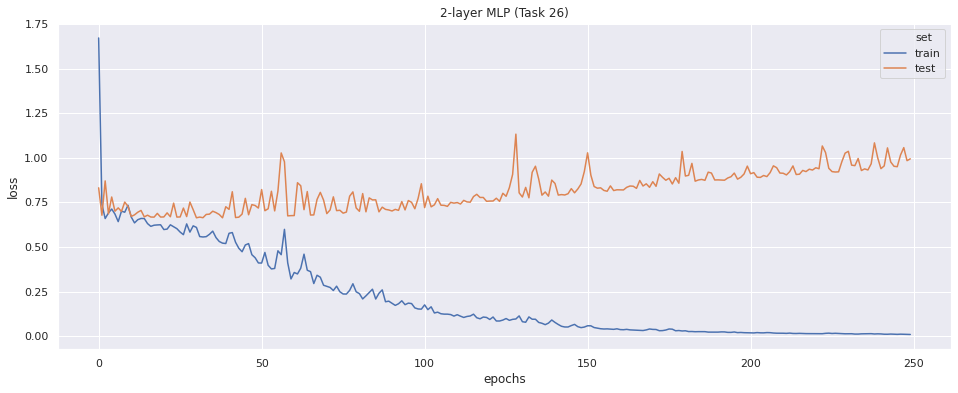

In [0]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="epochs", y="loss", hue= "set", data=training_history).set_title("2-layer MLP (Task 26)")
plt.savefig(PROJECT_PATH+'/results/MLP_loss_task26.png')

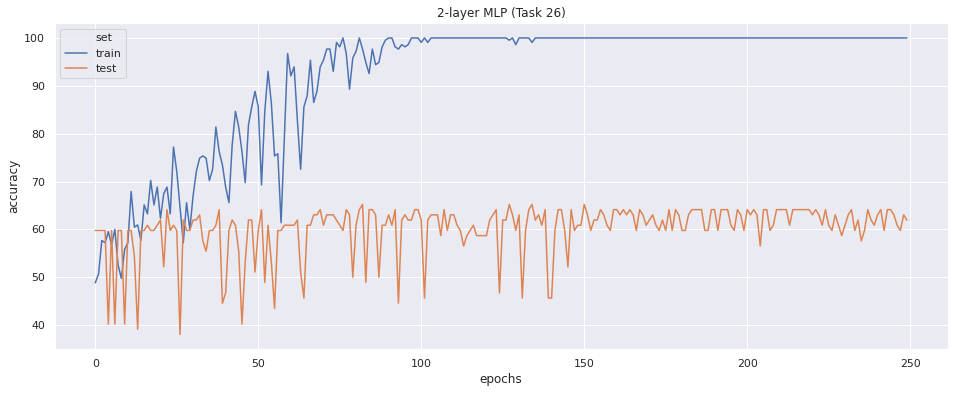

In [0]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="epochs", y="accuracy", hue= "set", data=training_history).set_title("2-layer MLP (Task 26)")
plt.savefig(PROJECT_PATH+'/results/MLP_accuracy_task26.png')

In [0]:
### DietNet TRAINING LOOP ###
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

def train_pass_diet(model, data_loader, optimizer, device):
    model.train()

    pass_loss = 0.0
    total = 0.0
    correct = 0.0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        # labels = labels.to(device)

        optimizer.zero_grad()

        x_hat, y_hat = model(inputs)
        # loss = criterion(outputs, labels)
        loss1 = criterion1(y_hat.squeeze(1), labels)
        loss2 = criterion2(x_hat, inputs)
        loss = ALPHA*loss1 + BETA*loss2

        loss.to(device)
        loss.backward()
        optimizer.step()
        
        pass_loss += loss.item()
        _, predicted = torch.max(y_hat.data, 1)

        predicted = predicted.cpu().numpy()
        labels = labels.cpu().numpy()
        total += len(labels)
        correct += (predicted == labels).sum()
    accuracy = (100 * correct / total)

    return pass_loss/len(data_loader), accuracy

def test_pass_diet(model, data_loader, device):
  pass_loss = 0.0

  for inputs, labels in data_loader:
        
      inputs = inputs.to(device)
      labels = labels.to(device).long()

      model.eval()
      x_hat, y_hat = model(inputs)
      
      loss1 = criterion1(y_hat.squeeze(1), labels)
      loss2 = criterion2(x_hat, inputs)
      loss = ALPHA*loss1 + BETA*loss2
      
      pass_loss += loss.item()
      _, predicted = torch.max(y_hat.data, 1)

      predicted = predicted.cpu().numpy()
      labels = labels.cpu().numpy()

      total = len(labels)
      correct = (predicted == labels).sum()
      accuracy = (100 * correct / total)

      return pass_loss/len(data_loader), accuracy


def run_training_diet(model, nb_epochs, train_loader, test_loader, device, lr):
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  progress_bar = tqdm(range(nb_epochs))
  loss_history = []
  best_acc=0
  for epoch in progress_bar:
      train_loss, train_acc = train_pass_diet(model, train_loader, optimizer, device)
      test_loss, test_acc = test_pass_diet(model, test_loader, device)
      loss_history.append(
          {"loss": train_loss, "accuracy": train_acc, "set": "train", "epochs": epoch}
      )
      loss_history.append(
          {"loss": test_loss, "accuracy": test_acc,"set": "test", "epochs": epoch}
      )
      if test_acc>best_acc:
          best_acc = test_acc
  print("best test accuracy: ", best_acc)      
  return pd.DataFrame(loss_history)


In [0]:
class DietNet(nn.Module):
    def __init__(self, feature_matrix, num_classes, device, featmatsize, embedding_size=500):   
        super(DietNet, self).__init__()
        self.embedding_size = embedding_size
        self.number_of_tasks_minus_one = featmatsize 
        self.number_of_genes = 20530
        feature_matrix = torch.tensor(feature_matrix, requires_grad=False).float()
        self.feature_matrix = feature_matrix.to(device)

        self.predictor = nn.Linear(self.embedding_size, num_classes) 

        # Definir les parametres du reseau auxiliaire 1 (predit les parametres de l'encoder)
        self.aux1 = nn.Linear(self.number_of_tasks_minus_one, self.embedding_size)
        self.hidden1 = nn.Linear(self.embedding_size, self.embedding_size)

        # Definir les parametres du reseau auxiliaire 2 (predit les parametres du decoder)
        self.aux2 = nn.Linear(self.number_of_tasks_minus_one, self.embedding_size)
        self.hidden2 = nn.Linear(self.embedding_size, self.embedding_size)

    def forward(self, x):
        # Loop over feature matrix to compute W_e
        W_e = F.relu(self.aux1(self.feature_matrix.T).T)
        W_e = self.hidden1(W_e.T) 
        latent = F.relu(torch.matmul(x, W_e))

        # Loop over feature matrix to compute W_d
        W_d = F.relu(self.aux2(self.feature_matrix.T))  
        W_d = self.hidden2(W_d) 
        x_hat = torch.matmul(latent, W_d.T) 

        y_hat = self.predictor(latent)

        return x_hat, y_hat

In [0]:
ALPHA = 1   # accuracy
BETA = 0.000000001   # reconstruction
seed=0
device="cuda"
random.seed(seed)
torch.manual_seed(seed)
LR = 0.0000005

DietNet_model = DietNet(feature_matrix, num_classes, device, 173, 500)
training_history_diet = run_training_diet(DietNet_model, 500, train_loader, test_loader, device, LR)

In [0]:
training_history_diet

,loss,accuracy,set,epochs
0,112495.128348,60.000000,train,0
1,110521.960938,59.782609,test,0
2,108854.968750,60.000000,train,1
3,106580.031250,59.782609,test,1
4,105447.112723,60.000000,train,2
...,...,...,...,...
995,151.344574,43.478261,test,497
996,157.205704,51.162791,train,498
997,152.890839,46.739130,test,498
998,161.695666,52.093023,train,499


In [0]:
test = training_history_diet[training_history_diet.set == 'test']
print(test.accuracy.max())
last100 = test[-100:]
print(last100.accuracy.mean())

60.869565217391305
43.30434782608694


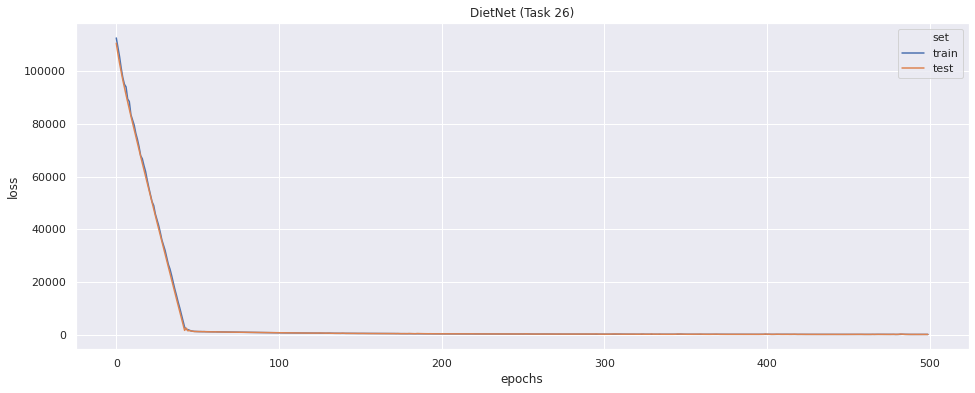

In [0]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="epochs", y="loss", hue= "set", data=training_history_diet).set_title("DietNet (Task 26)")
plt.savefig(PROJECT_PATH+'/results/DietNet-featmat173_loss_task26.png')

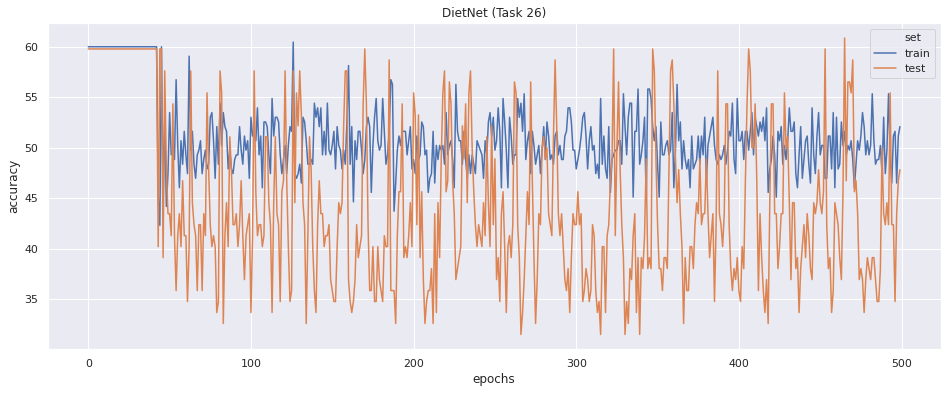

In [0]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="epochs", y="accuracy", hue= "set", data=training_history_diet).set_title("DietNet (Task 26)")
plt.savefig(PROJECT_PATH+'/results/DietNet-featmat173_accuracy_task26.png')

In [0]:
ALPHA = 1   # accuracy
BETA = 0.000000001   # reconstruction
seed=0
device="cuda"
random.seed(seed)
torch.manual_seed(seed)
LR = 0.0000005

DietNet_model = DietNet(feature_matrix5, num_classes, device, 865, 500)
training_history_diet5 = run_training_diet(DietNet_model, 500, train_loader, test_loader, device, LR)

In [0]:
test = training_history_diet5[training_history_diet5.set == 'test']
print(test.accuracy.max())
last100 = test[-100:]
print(last100.accuracy.mean())

59.78260869565217
53.45652173913042


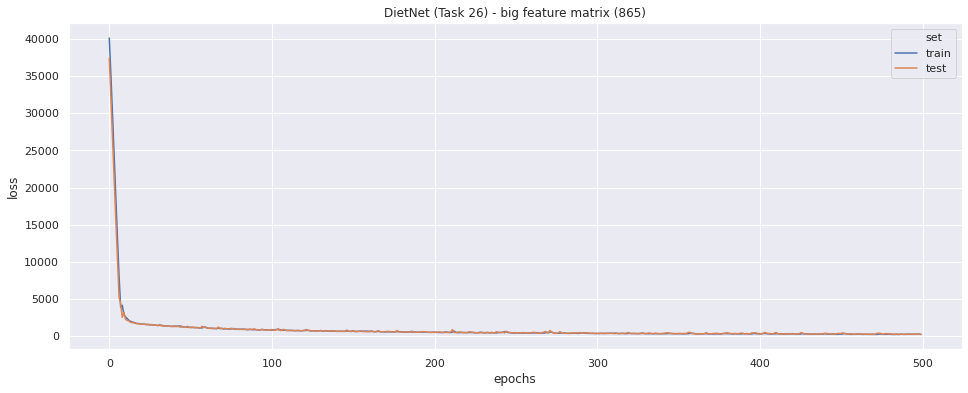

In [0]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="epochs", y="loss", hue= "set", data=training_history_diet5).set_title("DietNet (Task 26) - big feature matrix (865)")
plt.savefig(PROJECT_PATH+'/results/DietNet-featmat865_loss_task26.png')

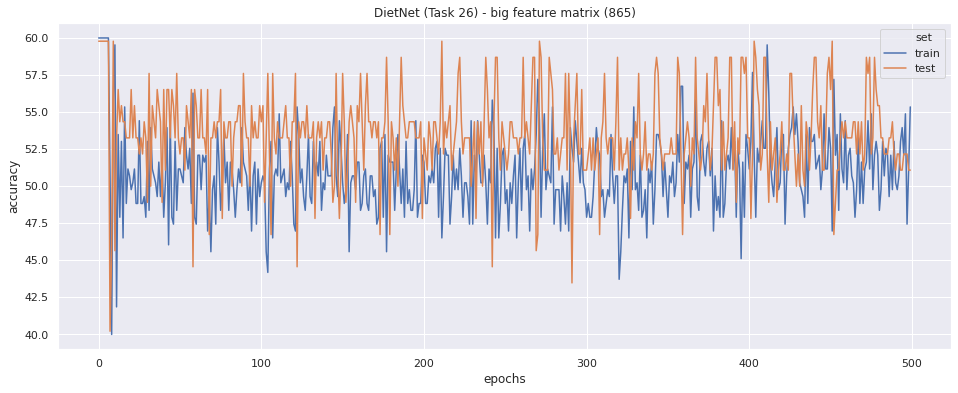

In [0]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="epochs", y="accuracy", hue= "set", data=training_history_diet5).set_title("DietNet (Task 26) - big feature matrix (865)")
plt.savefig(PROJECT_PATH+'/results/DietNet-featmat865_accuracy_task26.png')